In [49]:
import pandas as pd
import numpy as np
import os
#import what is needed for pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

### Dataset manipulation

In [50]:
mutations  = pd.read_csv('data/OmicsSomaticMutations.csv')
#filter by column Hugo_symbol == 'TP53'
mutations = mutations[mutations['HugoSymbol'] == 'TP53']

C:\Users\tommy\AppData\Local\Temp\ipykernel_35584\3768806862.py:1: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations  = pd.read_csv('data/OmicsSomaticMutations.csv')


In [51]:
model = pd.read_csv('data/Model.csv')
expression = pd.read_csv('data/OmicsExpressionProteinCodingGenesTPMLogp1.csv')

In [52]:
#rename the first column of expression to 'ModelID'
expression.rename(columns={expression.columns[0]: 'ModelID'}, inplace=True)

In [53]:
mutations['VariantType'] = mutations['VariantType'].astype('category')
# Convert the 'VariantType' column to categorical
category_mapping = dict(enumerate(mutations['VariantType'].cat.categories))
print(category_mapping)
mutations['VariantType'] = mutations['VariantType'].cat.codes

{0: 'SNV', 1: 'deletion', 2: 'insertion', 3: 'substitution'}


In [54]:
merged = pd.merge(expression, mutations[['ModelID', 'HugoSymbol', 'VariantType']], on='ModelID', how='left')
merged['VariantType'] = merged['VariantType'].fillna(4)
#change the type of the 'VariantType' column to int
merged['VariantType'] = merged['VariantType'].astype(int)

In [55]:
# create a boolean column 'Mutated' which is 1 if 'HugoSymbol' is not null and 0 if it is null
merged['Mutated'] = np.where(merged['HugoSymbol'].isnull(), 0, 1) 
#count number of mutated and non mutated samples
merged['Mutated'].value_counts()

Mutated
1    1108
0     687
Name: count, dtype: int64

In [56]:
# Check how many samples are in each category
print(merged['VariantType'].value_counts())

VariantType
0    932
4    687
1    125
2     33
3     18
Name: count, dtype: int64


### PCA Analysis v1 (scale before)

In [57]:
#run pca on the merged dataframe
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca = PCA(n_components=128)
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca_input = merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
#standardize the data
scaler = StandardScaler()
pca_input = scaler.fit_transform(pca_input)
#fit the pca model
pca.fit(pca_input)
#transform the data
pca_result = pca.transform(pca_input)
#convert to dataframe
pca_result = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
#add the column 'Mutated' to the pca_result dataframe
pca_result['Mutated'] = merged['Mutated'].values
#add the column 'ModelID' to the pca_result 
pca_result['ModelID'] = merged['ModelID'].values
#add the column 'VariantType' to the pca_result
pca_result['VariantType'] = merged['VariantType'].values

### PCA Analysis v2 (scale after)

In [58]:
#run pca on the merged dataframe
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca = PCA(n_components=128)
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca_input = merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
#fit the pca model
pca.fit(pca_input)
#transform the data
pca_result = pca.transform(pca_input)
#standardize the data
scaler = StandardScaler()
pca_result = scaler.fit_transform(pca_result)
#convert to dataframe
pca_result = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
#add the column 'Mutated' to the pca_result dataframe
pca_result['Mutated'] = merged['Mutated'].values
#add the column 'ModelID' to the pca_result 
pca_result['ModelID'] = merged['ModelID'].values
#add the column 'VariantType' to the pca_result
pca_result['VariantType'] = merged['VariantType'].values

### Model 1: Random Forest

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       194
           1       0.95      0.94      0.95       171
           2       0.99      1.00      0.99       176
           3       0.99      1.00      1.00       193
           4       0.80      0.80      0.80       191

    accuracy                           0.90       925
   macro avg       0.90      0.90      0.90       925
weighted avg       0.90      0.90      0.90       925



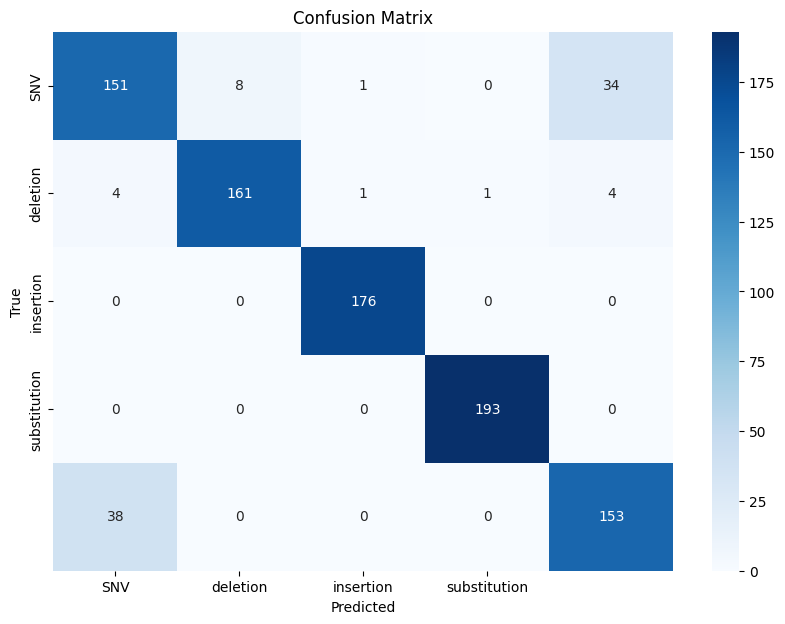

In [59]:
#perform a multiclass classification using the pca_result dataframe for the variation type
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
X = pca_result.drop(columns=['ModelID', 'Mutated', 'VariantType'])
y = pca_result['VariantType']
# #perform upsampling using smote
# smote = SMOTE(random_state=42, sampling_strategy='auto')
# X, y = smote.fit_resample(X, y)
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X, y = adasyn.fit_resample(X, y)
#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#predict the test set
y_pred = rf.predict(X_test)
#predict the probabilities of the test set
y_pred_proba = rf.predict_proba(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred)
#plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Multiclassification only on mutated observations

In [61]:
mut = merged[merged['Mutated'] == 1]


In [62]:
#run pca on the merged dataframe
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca = PCA(n_components=128)
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca_input = mut.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
#standardize the data
scaler = StandardScaler()
pca_input = scaler.fit_transform(pca_input)
#fit the pca model
pca.fit(pca_input)
#transform the data
pca_result = pca.transform(pca_input)
#convert to dataframe
pca_result = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
#add the column 'Mutated' to the pca_result dataframe
pca_result['Mutated'] = mut['Mutated'].values
#add the column 'ModelID' to the pca_result 
pca_result['ModelID'] = mut['ModelID'].values
#add the column 'VariantType' to the pca_result
pca_result['VariantType'] = mut['VariantType'].values

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       210
           1       0.95      0.97      0.96       175
           2       0.99      1.00      1.00       175
           3       0.99      0.99      0.99       181

    accuracy                           0.98       741
   macro avg       0.98      0.98      0.98       741
weighted avg       0.98      0.98      0.98       741



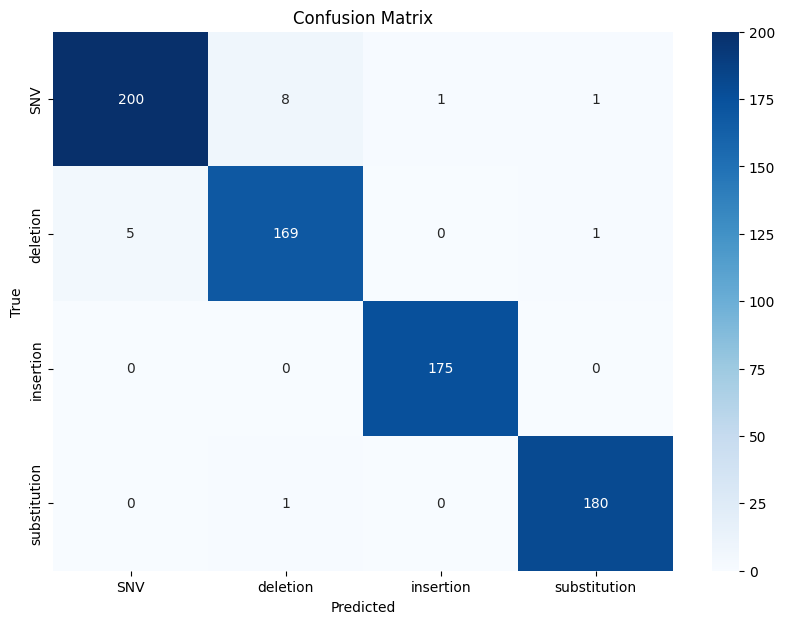

In [63]:
#perform a multiclass classification using the pca_result dataframe for the variation type
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
X = pca_result.drop(columns=['ModelID', 'Mutated', 'VariantType'])
y = pca_result['VariantType']
# #perform upsampling using smote
# smote = SMOTE(random_state=42, sampling_strategy='auto')
# X, y = smote.fit_resample(X, y)
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X, y = adasyn.fit_resample(X, y)
#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#predict the test set
y_pred = rf.predict(X_test)
#predict the probabilities of the test set
y_pred_proba = rf.predict_proba(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred)
#plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()